In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scdna_replication_tools.plot_utils import plot_cell_cn_profile2, get_metacohort_feature_cmap

In [2]:
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True

despine_offset = 0
despine_trim = True

### Load data showing the PCA results from clone RT matrix

In [3]:
pca_var = pd.read_csv('scdna_replication_paper/analysis/rt_model/clone_pca_explained_variance.csv.gz')

pca_var['cumulative_variance'] = pca_var['explained_variance'].cumsum()

pca_var.tail()

,PC,explained_variance,cumulative_variance
15,16,0.005990,0.858410
16,17,0.005761,0.864171
17,18,0.005329,0.869500
18,19,0.004848,0.874347
19,20,0.004538,0.878886


In [4]:
def plot_pca_var(df, ax):
    # plot a lineplot of the cumulative explained variance for each PC
    sns.lineplot(data=df, x='PC', y='cumulative_variance', marker='o', color='black', ax=ax, linewidth=1, markersize=3)
    ax.set_ylabel('cumulative explained variance')
    ax.set_xticks([1, 5, 10, 15, 20])
    ax.set_title('PCA of clone RT profiles')
    sns.despine(ax=ax, offset=despine_offset, trim=despine_trim)
    

In [5]:
feature_coef_df = pd.read_csv('scdna_replication_paper/analysis/rt_model/clone_pca_regression_coefficients.csv.gz')
# list of features to use in the regression
# note that the signature and type columns are one-hot encoded
feature_cols = [
    'ploidy', 'type_GM18507', 'type_T47D', 'type_hTERT', 'type_OV2295', 'type_HGSOC', 'type_TNBC',
    'signature_HRD', 'signature_TD', 'signature_FBI'
]
feature_coef_df.head()

,feature,coef,PC,log10_abs_coef,metafeature
0,ploidy,-8.706227,PC1,0.939830,ploidy
1,type_GM18507,-6.626555,PC1,0.821288,type
2,type_T47D,-11.087349,PC1,1.044828,type
3,type_hTERT,-30.616855,PC1,1.485961,type
4,type_OV2295,-8.092294,PC1,0.908072,type


In [22]:
def plot_pca_feature_coeffs(feature_coef_df, feature_cols, ax):
    sns.barplot(data=feature_coef_df, x='feature', y='log10_abs_coef', hue='PC', ax=ax, palette='viridis', errwidth=0.5)
    ax.set_ylabel('log10(abs(coefficient))')
    ax.set_xlabel('')
    ax.set_title('Multivariate linear regression of PCs\nusing K-fold CV')
    # reset the x-tick labels to rename '_' to '\n'
    ax.set_xticklabels([x.replace('_', '\n') for x in feature_cols])
    sns.despine(ax=ax, offset=0, trim=despine_trim)
    # rotate the x-tick labels by 45 degrees
    ax.tick_params(axis='x', rotation=30)

### Load data showing the beta importance terms from the second factor model

In [7]:
beta_importance = pd.read_csv('scdna_replication_paper/analysis/rt_model/beta_importance_posteriors.csv.gz')
beta_importance.head()

,beta_cell_type_importance,beta_signature_importance,beta_wgd_importance,beta_global_rt_importance
0,30.292982,18.442316,24.453667,48.235203
1,28.120296,18.181242,27.489836,51.128624
2,31.182678,18.109863,24.409735,54.163450
3,28.446873,17.237190,27.209488,56.783060
4,30.170746,17.781757,26.884802,53.495617


In [8]:
def plot_beta_importance(beta_importance, ax):
    # plot a barplot of the mean beta importance for each feature
    # each column has its own bar and color
    cmap = get_metacohort_feature_cmap()
    xticklabels = []
    beta_columns = ['beta_global_rt_importance', 'beta_cell_type_importance', 'beta_signature_importance', 'beta_wgd_importance']
    labels = ['global', 'type', 'signature', 'ploidy']
    for i, col in enumerate(beta_columns):
        # remove the beta_ prefix and _importance suffix from the column name for plotting
        label = labels[i]
        xticklabels.append(label)
        ydata = beta_importance[col].values
        yerr = np.array([np.mean(ydata) - np.percentile(ydata, 2.5), np.percentile(ydata, 97.5) - np.mean(ydata)]).reshape(2, 1)
        ax.bar(x=i, height=np.mean(ydata), yerr=yerr, color=cmap[label], label=label, linewidth=0.5)
    ax.set_ylabel('mean beta importance\n95% CI')
    ax.set_xlabel('feature')
    ax.set_xticklabels([], rotation=90)
    ax.set_title('Factor model\nfeature importance')
    ax.legend(loc='upper right')
    sns.despine(ax=ax, offset=despine_offset, trim=despine_trim)

### Load feature specific RT profiles learned by the factor model and plot all of them

In [9]:
def compute_median_and_ci(df, col_prefix_list):
    ''' For each rt profile, compute the median and 95% CI of the posterior distribution. '''
    # initialize empty dataframe
    out_df = pd.DataFrame()
    for col_prefix in col_prefix_list:
        # subset df to just the columns with this prefix
        col_names = [col for col in df.columns if (col.startswith(col_prefix)) or (col in ['chr', 'start', 'end'])]
        temp_df = df[col_names]
        # set chr, start, end as the index
        temp_df = temp_df.set_index(['chr', 'start', 'end'])
        # compute the median and 95% CI of the posterior distribution across all rows in temp_df
        median = temp_df.median(axis=1)
        ci_lower = temp_df.quantile(0.025, axis=1)
        ci_upper = temp_df.quantile(0.975, axis=1)
        median_colname = col_prefix + '_median'
        ci_lower_colname = col_prefix + '_ci_lower'
        ci_upper_colname = col_prefix + '_ci_upper'
        temp_summary_df = pd.DataFrame({median_colname: median, ci_lower_colname: ci_lower, ci_upper_colname: ci_upper}, index=temp_df.index)

        # if out_df is empty, set it equal to temp_summary_df
        if out_df.empty:
            out_df = temp_summary_df
        # otherwise, merge temp_summary_df with out_df
        else:
            out_df = out_df.merge(temp_summary_df, left_index=True, right_index=True)
        
    # reset index so that chr, start, end are now columns
    out_df = out_df.reset_index()

    return out_df

In [10]:
# read in the posterior rt profiles
rt_profiles = pd.read_csv('scdna_replication_paper/analysis/rt_model/rt_profile_posteriors.csv.gz')

# list of all the rt profiles that need to be processed
col_prefix_list = ['global_rt', 'ct_hgsoc', 'ct_tnbc', 'ct_htert', 'ct_ov2295', 'ct_t47d', 'ct_gm18507', 'sig_fbi', 'sig_hrd', 'sig_td', 'wgd_rt', 'ngd_rt']

# compute the median and 95% CI of the posterior distribution for each rt profile
rt_profiles = compute_median_and_ci(rt_profiles, col_prefix_list)

# set the chromosome column as a categorical variable
rt_profiles['chr'] = rt_profiles['chr'].astype('str').astype('category')

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [16]:
def plot_rt_profile_posteriors(rt_profiles, col_prefix_list, axes, chrom_labels_to_remove):
    for ax, col_prefix in zip(axes, col_prefix_list):
        cmap = get_metacohort_feature_cmap()
        if col_prefix.startswith('global'):
            color = cmap['global']
        elif col_prefix.startswith('ct'):
            color = cmap['type']
        elif col_prefix.startswith('sig'):
            color = cmap['signature']
        elif col_prefix.startswith('wgd') or col_prefix.startswith('ngd'):
            color = cmap['ploidy']
        median_colname = col_prefix + '_median'
        ci_lower_colname = col_prefix + '_ci_lower'
        ci_upper_colname = col_prefix + '_ci_upper'
        plot_cell_cn_profile2(ax, rt_profiles, median_colname, cn_field_name=None, max_cn=None,
                            chromosome=None, s=1, squashy=False, color=color, alpha=1,
                            lines=True, label=None, scale_data=False, rawy=True,
                            rasterized=True, min_ci_field_name=ci_lower_colname, max_ci_field_name=ci_upper_colname,
                            chrom_labels_to_remove=chrom_labels_to_remove)
        title = col_prefix.replace('global_rt', 'Global RT').replace('ct_', 'type = ').replace('sig_', 'signature = ').replace('wgd_rt', 'ploidy = WGD').replace('ngd_rt', 'ploidy = NGD')
        # rename the features to have correct capitalization
        title = title.replace('hgsoc', 'HGSOC').replace('tnbc', 'TNBC').replace('htert', 'hTERT').replace('ov2295', 'OV2295').replace('t47d', 'T47D').replace('gm18507', 'GM18507')
        title = title.replace('fbi', 'FBI').replace('hrd', 'HRD').replace('td', 'TD')
        ax.set_title(title)
        ax.set_ylabel('Posterior RT\n<-later | earlier->')
        ax.set_xlabel('')
    
    # set the y-limits and tick labels to be the same for all axes
    y_min = np.min([ax.get_ylim()[0] for ax in axes])
    y_max = np.max([ax.get_ylim()[1] for ax in axes])
    yticks = [-0.05, 0.0, 0.05]
    for ax in axes:
        ax.set_ylim([y_min, y_max])
        ax.set_yticks(yticks)

    # set the y axis labels to '' for all odd elements in axes
    for i, ax in enumerate(axes):
        if i % 2 == 1:
            ax.set_ylabel('')
    
    for ax in [axes[-2], axes[-1]]:
        ax.set_xlabel('chromosome')
    
    for ax in axes:
        sns.despine(ax=ax, offset=10, trim=True)

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always r

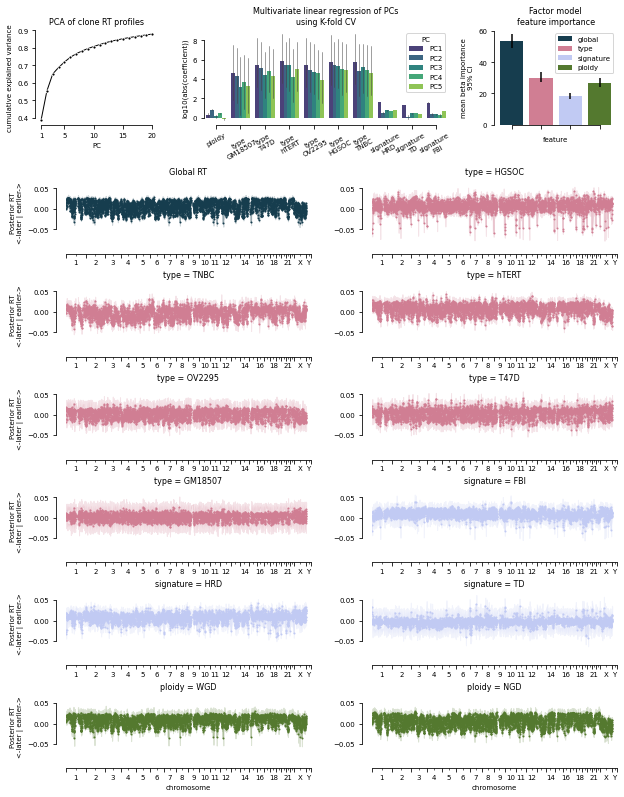

In [23]:
# create figure
fig = plt.figure(figsize=(8.5, 11))

# add an axis in the top left corner
ax0 = fig.add_axes([0.05, 0.85, 0.2, 0.12])
ax0.set_title('ax0')

# add an axis in the top middle
ax1 = fig.add_axes([0.325, 0.85, 0.4, 0.12])
ax1.set_title('ax1')

# add an axis in the top right corner
ax2 = fig.add_axes([0.8, 0.85, 0.2, 0.12])
ax2.set_title('ax2')

# add axes for the feature RT profiles
ax3 = fig.add_axes([0.1, 0.7, 0.4, 0.08])
ax3.set_title('ax3')
ax4 = fig.add_axes([0.6, 0.7, 0.4, 0.08], sharey=ax3)
ax4.set_title('ax4')
# repeat this pattern above for 5 more rows of axes
ax5 = fig.add_axes([0.1, 0.57, 0.4, 0.08], sharey=ax3)
ax5.set_title('ax5')
ax6 = fig.add_axes([0.6, 0.57, 0.4, 0.08], sharey=ax3)
ax6.set_title('ax6')
ax7 = fig.add_axes([0.1, 0.44, 0.4, 0.08], sharey=ax3)
ax7.set_title('ax7')
ax8 = fig.add_axes([0.6, 0.44, 0.4, 0.08], sharey=ax3)
ax8.set_title('ax8')
ax9 = fig.add_axes([0.1, 0.31, 0.4, 0.08], sharey=ax3)
ax9.set_title('ax9')
ax10 = fig.add_axes([0.6, 0.31, 0.4, 0.08], sharey=ax3)
ax10.set_title('ax10')
ax11 = fig.add_axes([0.1, 0.18, 0.4, 0.08], sharey=ax3)
ax11.set_title('ax11')
ax12 = fig.add_axes([0.6, 0.18, 0.4, 0.08], sharey=ax3)
ax12.set_title('ax12')
ax13 = fig.add_axes([0.1, 0.05, 0.4, 0.08], sharey=ax3)
ax13.set_title('ax13')
ax14 = fig.add_axes([0.6, 0.05, 0.4, 0.08], sharey=ax3)
ax14.set_title('ax14')


chrom_labels_to_remove = ['13', '15', '17', '19', '20', '22']

# plot the cumulative explained variance for each PC
plot_pca_var(pca_var, ax0)

# plot the feature coefficients for each PC
plot_pca_feature_coeffs(feature_coef_df, feature_cols, ax1)

# plot the beta importance for each meta feature
plot_beta_importance(beta_importance, ax2)

# plot the RT profiles for each feature in ax3-ax14
plot_rt_profile_posteriors(rt_profiles, col_prefix_list, [ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14], chrom_labels_to_remove)

# draw a dashed lines around the boundaries of the entire figure to know where to crop
# ax_bottom = fig.add_axes([0, 0, 1, 0.01])
# ax_top = fig.add_axes([0, 0.99, 1, 0.01])
# ax_left = fig.add_axes([0, 0, 0.01, 1])
# ax_right = fig.add_axes([0.99, 0, 0.01, 1])
# for ax in [ax_bottom, ax_top, ax_left, ax_right]:
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.set_xticklabels([])
#     ax.set_yticklabels([])

# save the figure
fig.savefig('scdna_replication_paper/manuscript/extended_data_figs/figED5.pdf', dpi=300, bbox_inches='tight')

plt.show()